In [1]:
import os
import numpy as np
import glob
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, BatchNormalization, Conv2D, Conv3D,
    MaxPooling2D, MaxPooling3D, TimeDistributed, Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import random

In [2]:
# Hàm đọc dữ liệu
def read_tif_files(base_dir):
    """ 
    Duyệt qua tất cả các file .tif trong cấu trúc: 
    base_dir/yyyy/mm/dd/*.tif và trả về một dictionary với key là ngày (YYYY-MM-DD) 
    và value là danh sách các file chứa dữ liệu và metadata. 
    """
    pattern = os.path.join(base_dir, '*', '*', '*', '*.tif')
    file_list = glob.glob(pattern)
    file_list.sort()
    print(f"Tìm được {len(file_list)} file trong thư mục {base_dir}")
    
    data_dict = {}
    for file_path in file_list:
        parts = file_path.split(os.sep)
        year, month, day = parts[-4], parts[-3], parts[-2]
        date_str = f"{year}-{month}-{day}"
        
        try:
            with rasterio.open(file_path) as src:
                data = src.read(1)
                meta = src.meta
        except Exception as e:
            print(f"Lỗi đọc file {file_path}: {e}")
            continue
            
        data_dict.setdefault(date_str, []).append({
            'file': file_path,
            'data': data,
            'meta': meta
        })
    
    return data_dict

def preprocess_data(data_dict, fill_method='mean'):
    """
    Tiền xử lý dữ liệu, xử lý giá trị NaN và chuẩn hóa dữ liệu
    
    Args:
        data_dict: Dictionary chứa dữ liệu
        fill_method: Phương pháp điền giá trị thiếu ('mean', 'median', 'zero')
    
    Returns:
        Dictionary đã được xử lý
    """
    processed_dict = {}
    
    for date, data_list in data_dict.items():
        processed_dict[date] = []
        
        for item in data_list:
            data = item['data']
            
            # Xác định các giá trị NaN hoặc giá trị khuyết
            invalid_mask = ~np.isfinite(data) | (data < -9000)  # Giả sử -9999 là giá trị fill value
            
            # Điền giá trị thiếu
            if fill_method == 'mean' and not np.all(invalid_mask):
                fill_value = np.nanmean(data[~invalid_mask])
            elif fill_method == 'median' and not np.all(invalid_mask):
                fill_value = np.nanmedian(data[~invalid_mask])
            else:
                fill_value = 0
                
            data_filled = data.copy()
            data_filled[invalid_mask] = fill_value
            
            processed_item = {
                'file': item['file'],
                'data': data_filled,
                'meta': item['meta']
            }
            
            processed_dict[date].append(processed_item)
    
    return processed_dict

def align_data_by_dates(radar_data, era5_data):
    """
    Sắp xếp và căn chỉnh dữ liệu theo ngày tháng.
    
    Returns:
        Các array chứa dữ liệu đã được căn chỉnh theo thời gian
    """
    common_dates = set(radar_data.keys())
    
    # Tìm các ngày có đầy đủ dữ liệu trong cả 2 nguồn
    for var in era5_data:
        common_dates &= set(era5_data[var].keys())
    
    common_dates = sorted(list(common_dates))
    print(f"Tìm thấy {len(common_dates)} ngày có đầy đủ dữ liệu")
    
    if len(common_dates) == 0:
        raise ValueError("Không tìm thấy ngày nào có đầy đủ dữ liệu từ tất cả các nguồn")
    
    # Khởi tạo danh sách lưu trữ
    aligned_radar = []
    aligned_era5 = {var: [] for var in era5_data}
    
    # Sắp xếp dữ liệu theo ngày
    for date in common_dates:
        # Thêm dữ liệu radar
        for item in radar_data[date]:
            aligned_radar.append({
                'date': date,
                'data': item['data'],
                'meta': item['meta']
            })
        
        # Thêm dữ liệu ERA5
        for var in era5_data:
            for item in era5_data[var][date]:
                aligned_era5[var].append({
                    'date': date,
                    'data': item['data'],
                    'meta': item['meta']
                })
    
    return aligned_radar, aligned_era5, common_dates

def normalize_data(data_list):
    """
    Chuẩn hóa dữ liệu về khoảng [0, 1] theo global min/max.
    Trường hợp min == max → tất cả giá trị = 0.
    """
    arrays = [item['data'] for item in data_list]
    global_min = min(np.min(arr) for arr in arrays)
    global_max = max(np.max(arr) for arr in arrays)

    normalized_list = []
    if global_max - global_min == 0:
        # Toàn bộ ảnh có cùng giá trị → trả về 0
        for item in data_list:
            normalized_item = item.copy()
            normalized_item['data'] = np.zeros_like(item['data'], dtype=np.float32)
            normalized_list.append(normalized_item)
    else:
        for item in data_list:
            normalized_item = item.copy()
            normalized_item['data'] = ((item['data'] - global_min) / (global_max - global_min)).astype(np.float32)
            normalized_list.append(normalized_item)

    normalization_params = {
        'min': global_min,
        'max': global_max
    }

    return normalized_list, normalization_params



def build_light_convlstm(input_shape, n_horizons):
    """
    Mô hình ConvLSTM nhẹ cho multi-horizon, tối ưu cho tốc độ:
    - Giảm số layer xuống 2
    - Giảm số filter
    - Dùng kernel nhỏ hơn
    - Loại bỏ recurrent_dropout để bật CuDNN path
    """
    model = Sequential()
    # Layer 1: fewer filters, kernel 3x3, return sequences
    model.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='tanh',             # CuDNN-optimized activation
        recurrent_activation='sigmoid',# CuDNN-optimized recurrent_activation
        stateful=False,
        input_shape=input_shape
    ))
    model.add(BatchNormalization())

    # Layer 2: final ConvLSTM, không return sequence
    model.add(ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        activation='tanh',
        recurrent_activation='sigmoid'
    ))
    model.add(BatchNormalization())

    # Output: 1x1 Conv để giảm nhẹ tính toán
    model.add(Conv2D(
        filters=n_horizons,
        kernel_size=(1, 1),
        padding='same',
        activation='linear'
    ))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model


def bayesian_model_builder(hp):
    # Search space
    filters1 = hp.Int('filters1', min_value=32, max_value=128, step=32)
    filters2 = hp.Int('filters2', min_value=16, max_value=64, step=16)
    kernel = hp.Choice('kernel_size', values=[3, 5])
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = Sequential()
    model.add(ConvLSTM2D(
        filters=filters1,
        kernel_size=(kernel, kernel),
        padding='same',
        return_sequences=True,
        activation='relu',
        recurrent_dropout=dropout,
        input_shape=input_shape  # sử dụng biến toàn cục input_shape
    ))
    model.add(BatchNormalization())

    model.add(ConvLSTM2D(
        filters=filters2,
        kernel_size=(kernel, kernel),
        padding='same',
        return_sequences=False,
        activation='relu',
        recurrent_dropout=dropout
    ))
    model.add(BatchNormalization())

    model.add(Conv2D(
        filters=n_horizons,  # sử dụng biến toàn cục n_horizons
        kernel_size=(3, 3),
        padding='same',
        activation='linear'
    ))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

def make_hourly_dataset(radar_data, era5_data, common_times,
                        seq_length=6, horizon_list=[1, 2, 3, 4, 5, 6],
                        batch_size=8):
    T = len(common_times)
    max_h = max(horizon_list)
    H, W = radar_data[0]['data'].shape
    C = 1 + len(era5_data)

    # 1) Chuẩn hóa
    norm_radar, radar_params = normalize_data(radar_data)
    norm_era5 = {var: normalize_data(lst)[0] for var, lst in era5_data.items()}

    frames = []
    for i in range(T):
        channels = [norm_radar[i]['data'][..., None]]
        for var in norm_era5:
            channels.append(norm_era5[var][i]['data'][..., None])
        frames.append(np.concatenate(channels, axis=-1).astype(np.float32))

    # 2) Dataset chỉ số
    ds = tf.data.Dataset.range(T)

    # ✅ 3) Map index → frame
    def load_frame(i):
        i = tf.cast(i, tf.int32)
        def np_load(idx):
            return frames[int(idx)]
        frame = tf.numpy_function(np_load, [i], tf.float32)
        frame.set_shape((H, W, C))  # cần set shape tĩnh cho TF graph
        return frame

    ds = ds.map(load_frame, num_parallel_calls=tf.data.AUTOTUNE)

    # 4) Tạo window
    ds = ds.window(size=seq_length + max_h, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda win: win.batch(seq_length + max_h))

    # 5) Tách X và y
    def split_xy(window):
        X = window[:seq_length]                      # (seq_length, H, W, C)
        ys = [window[seq_length + h - 1, ..., 0]     # chọn radar channel
              for h in horizon_list]
        y = tf.stack(ys, axis=-1)                    # (H, W, len(horizons))
        return X, y

    ds = ds.map(split_xy, num_parallel_calls=tf.data.AUTOTUNE)

    # ✅ 6) Dùng drop_remainder=True để bỏ batch lẻ
    ds = ds.batch(batch_size, drop_remainder=True)  # ⚠️ thêm drop_remainder
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds, radar_params


def make_predictions(model, input_data, radar_params):
    """
    Thực hiện dự báo đa-bước bằng 1 model duy nhất
    Args:
        model: Keras model xuất ra n_horizons kênh
        input_data: numpy array (N, seq_length, H, W, C)
        radar_params: dict chứa 'min' và 'max' để đổi ngược chuẩn hóa
    Returns:
        preds: numpy array (N, H, W, n_horizons)
    """
    # Dự báo
    preds = model.predict(input_data)
    # Đổi ngược chuẩn hóa về giá trị gốc
    min_val, max_val = radar_params['min'], radar_params['max']
    preds = preds * (max_val - min_val) + min_val
    # Loại giá trị âm
    preds[preds < 0] = 0
    return preds

def visualize_predictions_full_truth(original, preds, horizons, timestep=0, auto_scale=True, vmin=0, vmax=None):
    """
    Hiển thị toàn bộ thực tế & dự báo theo từng horizon tại timestep nhất định.
    original, preds: (N, H, W, len(horizons))
    """
    n = len(horizons)
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))

    # Handle when only 1 horizon
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, h in enumerate(horizons):
        true_data = original[timestep, ..., i]
        pred_data = preds[timestep, ..., i]

        # Tự động scale theo percentiles hoặc dùng fixed vmin/vmax
        if auto_scale:
            vmax_i = max(np.percentile(true_data, 99), np.percentile(pred_data, 99), 0.01)
        else:
            vmax_i = vmax

        im1 = axes[0, i].imshow(true_data, cmap='Blues', vmin=vmin, vmax=vmax_i)
        axes[0, i].set_title(f"Thực tế {h}h")
        plt.colorbar(im1, ax=axes[0, i])

        im2 = axes[1, i].imshow(pred_data, cmap='Blues', vmin=vmin, vmax=vmax_i)
        axes[1, i].set_title(f"Dự báo {h}h")
        plt.colorbar(im2, ax=axes[1, i])

    # Ghi nhãn dòng
    for ax in axes[:, 0]:
        ax.set_ylabel("THỰC TẾ" if ax in axes[0] else "DỰ BÁO", fontsize=14)

    fig.suptitle(f"Dự báo vs Thực tế tại timestep {timestep}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # để không đè title
    plt.show()


def split_dataset_safe(ds, train_ratio=0.8):
    batch_list = list(ds)
    total = len(batch_list)
    if total == 0:
        raise ValueError("❌ Dataset rỗng!")

    if total == 1:
        print("⚠️ Chỉ 1 batch, dùng làm train")
        return tf.data.Dataset.from_generator(
            lambda: iter(batch_list),
            output_signature=(
                tf.TensorSpec(shape=batch_list[0][0].shape, dtype=tf.float32),
                tf.TensorSpec(shape=batch_list[0][1].shape, dtype=tf.float32),
            )
        ), None

    train_cnt = max(1, int(train_ratio * total))
    def make_ds(data):
        return tf.data.Dataset.from_generator(
            lambda: iter(data),
            output_signature=(
                tf.TensorSpec(shape=batch_list[0][0].shape, dtype=tf.float32),
                tf.TensorSpec(shape=batch_list[0][1].shape, dtype=tf.float32),
            )
        )

    return make_ds(batch_list[:train_cnt]), make_ds(batch_list[train_cnt:])





In [3]:
# Đọc dữ liệu ERA5 và Radar
era5_base_dir = os.path.join("DATA_SV", "ERA5")
era5_vars = [
    'V850', 'V250', 'U850', 'U250', 'TCWV', 'TCW', 'TCLW',
    'SSHF', 'SLOR', 'SLHF', 'R850', 'R500', 'R250',
    'PEV', 'KX', 'ISOR', 'IE', 'EWSS', 'CIN', 'CAPE'
]
era5_data = {}
for var in era5_vars:
    var_dir = os.path.join(era5_base_dir, var)
    print(f"Đọc ERA5 cho biến {var}")
    era5_data[var] = read_tif_files(var_dir)

radar_dir = os.path.join("DATA_SV", "Precipitation", "Radar")
print("Đọc radar precipitation")
radar_data = read_tif_files(radar_dir)

Đọc ERA5 cho biến V850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\V850
Đọc ERA5 cho biến V250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\V250
Đọc ERA5 cho biến U850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\U850
Đọc ERA5 cho biến U250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\U250
Đọc ERA5 cho biến TCWV
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCWV
Đọc ERA5 cho biến TCW
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCW
Đọc ERA5 cho biến TCLW
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCLW
Đọc ERA5 cho biến SSHF
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SSHF
Đọc ERA5 cho biến SLOR
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SLOR
Đọc ERA5 cho biến SLHF
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SLHF
Đọc ERA5 cho biến R850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R850
Đọc ERA5 cho biến R500
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R500
Đọc ERA5 cho biến R250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R250
Đọc ERA5 cho biến PEV
Tìm được 2928 file

In [4]:

# Tiền xử lí dữ liệu
print("Tiền xử lý radar")
processed_radar = preprocess_data(radar_data, fill_method='zero')

print("Tiền xử lý ERA5")
processed_era5 = {
    var: preprocess_data(era5_data[var], fill_method='mean')
    for var in era5_data
}

# Căn chỉnh theo ngày
print("Căn chỉnh dữ liệu theo thời gian")
aligned_radar, aligned_era5, common_dates = align_data_by_dates(
    processed_radar, processed_era5
)
seq_length = 6
horizons   = [1,2,3,4,5,6]
batch_size = 8

print(f"Tạo dataset streaming với seq_length={seq_length}, horizons={horizons}")
ds, radar_params = make_hourly_dataset(
    aligned_radar, aligned_era5, common_dates,
    seq_length=seq_length,
    horizon_list=horizons,
    batch_size=batch_size
)

ds_train, ds_val = split_dataset_safe(ds)


Tiền xử lý radar
Tiền xử lý ERA5
Căn chỉnh dữ liệu theo thời gian
Tìm thấy 110 ngày có đầy đủ dữ liệu
Tạo dataset streaming với seq_length=6, horizons=[1, 2, 3, 4, 5, 6]


In [5]:

# --- 1) Lấy input_shape và n_horizons từ ds_train ---
x0, y0 = next(iter(ds_train))
input_shape = x0.shape[1:]   # (seq_length, H, W, C)
n_horizons  = y0.shape[-1]    # len(horizons)

# --- 2) Khởi callbacks ---
callbacks = [
    EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_mae', patience=7, factor=0.5),
    # ModelCheckpoint("model_multi_horizon.h5", monitor='val_mae', save_best_only=True)
]

# --- 3) Xây model ---
model = build_light_convlstm(
    input_shape=input_shape,
    n_horizons=n_horizons
)

# --- 4) Train trên tf.data.Dataset ---
print("Bắt đầu training đa-horizon model")
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=callbacks
)


Bắt đầu training đa-horizon model
Epoch 1/50


c:\Users\Ngoc Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      9/Unknown 25s 2s/step - loss: 0.6777 - mae: 0.5731

c:\Users\Ngoc Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.6441 - mae: 0.5532 - val_loss: 0.0106 - val_mae: 0.0803 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.0816 - mae: 0.2087 - val_loss: 0.0171 - val_mae: 0.0997 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0418 - mae: 0.1493 - val_loss: 0.0191 - val_mae: 0.1033 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0251 - mae: 0.1148 - val_loss: 0.0192 - val_mae: 0.1013 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0180 - mae: 0.0996 - val_loss: 0.0168 - val_mae: 0.0900 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.0128 - mae: 0.0824 - val_loss: 0.0154 - val_mae: 0.0887 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0086 - mae: 0.0652 - val_loss: 0.0131 - val_mae: 0.0824 - learning_rate: 0.0010
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


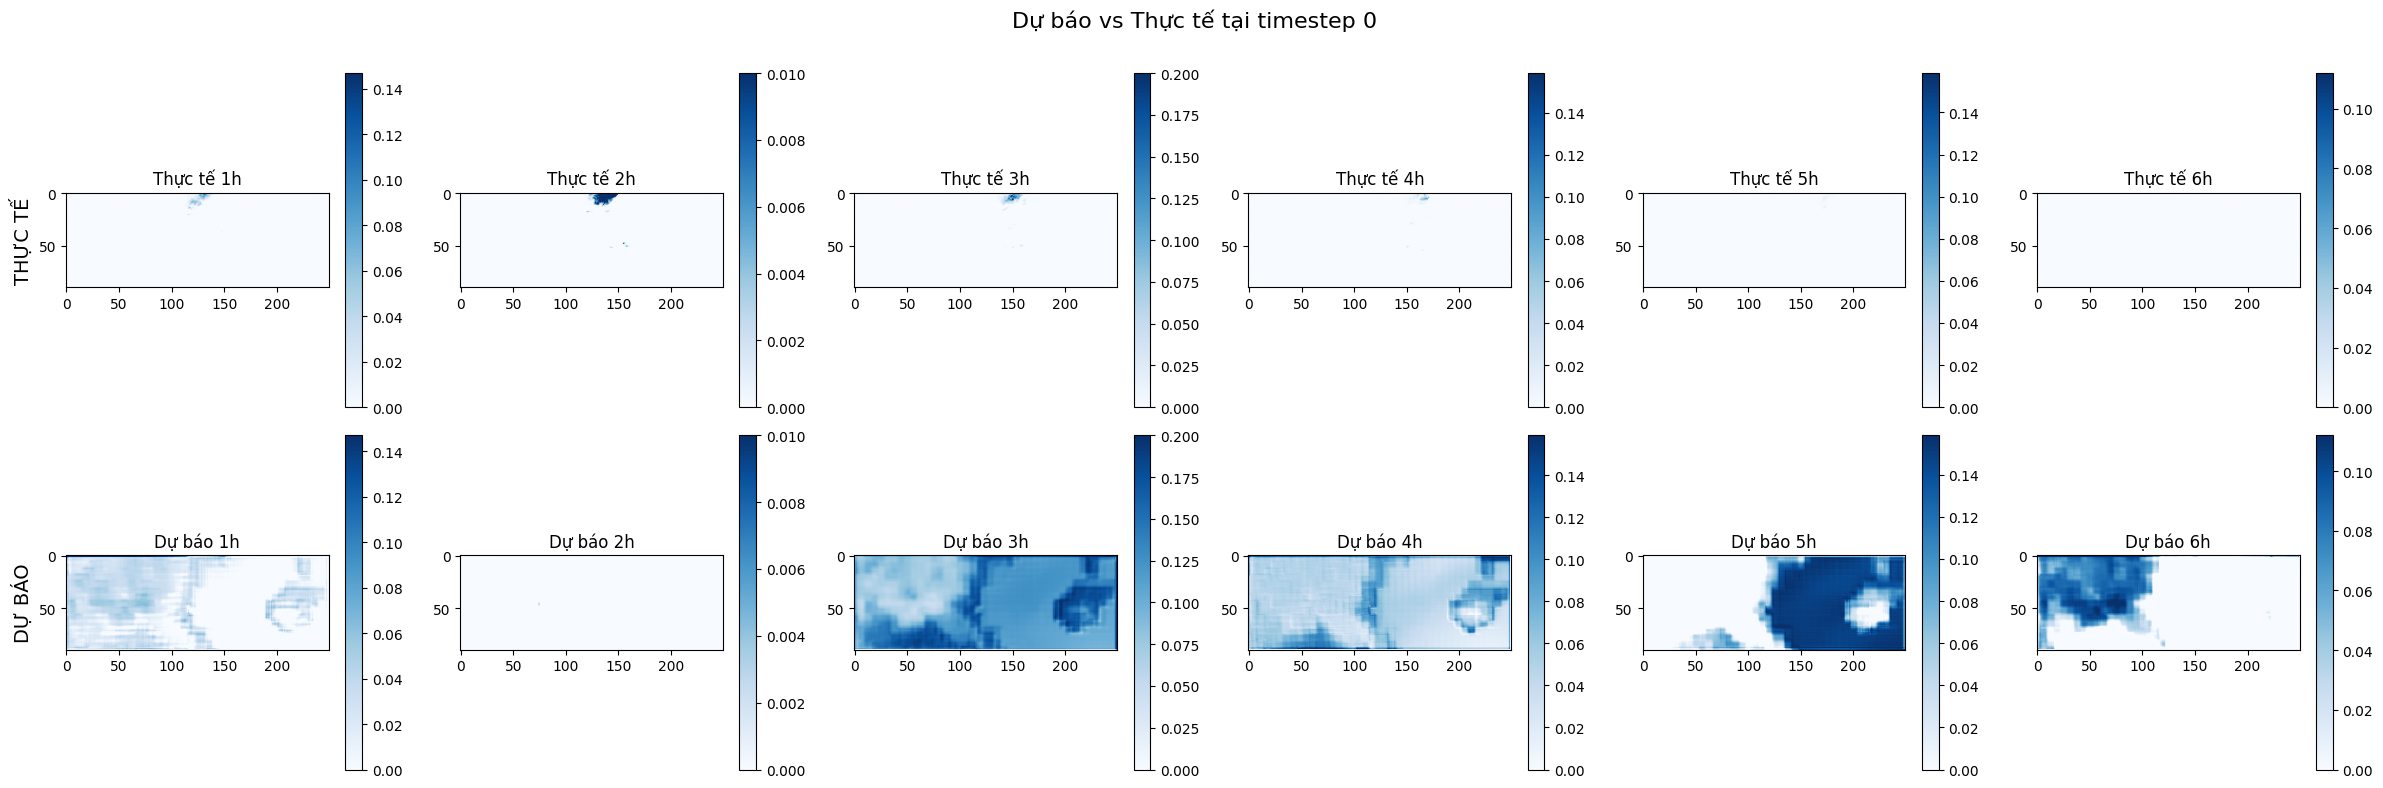

In [6]:

# Tạo danh sách các sample có mưa
nonzero_samples = []
for X_batch, y_batch in ds_train.take(20):  # chỉ duyệt 20 batch cho nhanh
    for i in range(X_batch.shape[0]):
        if tf.reduce_max(y_batch[i]) > 0:
            nonzero_samples.append((X_batch[i:i+1], y_batch[i:i+1]))

# Chọn ngẫu nhiên 1 sample
X_sample, y_sample = random.choice(nonzero_samples)
X_sample, y_sample = X_sample.numpy(), y_sample.numpy()

# Dự báo và hiển thị
y_pred = model.predict(X_sample)
visualize_predictions_full_truth(y_sample, y_pred, horizons)

In [7]:
# Gán biến toàn cục
input_shape = ds_train.element_spec[0].shape[1:]
n_horizons  = ds_train.element_spec[1].shape[-1]

# Khởi tạo tuner
tuner = kt.BayesianOptimization(
    bayesian_model_builder,
    objective='val_mae',
    max_trials=5,
    num_initial_points=5,
    directory='bayes_logs',
    project_name='conv_lstm_bayes'
)

# Tìm kiếm với tf.data.Dataset
tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=callbacks
)

# Lấy mô hình tốt nhất
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=callbacks
)


Trial 11 Complete [00h 38m 01s]
val_mae: 0.06098494306206703

Best val_mae So Far: 0.01329798437654972
Total elapsed time: 5d 05h 58m 27s
Best hyperparameters: {'filters1': 32, 'filters2': 16, 'kernel_size': 5, 'dropout': 0.4, 'learning_rate': 0.0005700367307339485}
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 0.8988 - mae: 0.7138 - val_loss: 1.6052e-04 - val_mae: 0.0081 - learning_rate: 5.7004e-04
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 0.2771 - mae: 0.3888 - val_loss: 2.8134e-04 - val_mae: 0.0120 - learning_rate: 5.7004e-04
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - loss: 0.1277 - mae: 0.2626 - val_loss: 2.4004e-04 - val_mae: 0.0117 - learning_rate: 5.7004e-04
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.0677 - mae: 0.1922 - val_loss: 1.2993e-04 - val_mae: 0.0089 - learning_rate: 5.7004e-04
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - loss: 0.0410 - mae: 0.1496 - val_loss: 1.5906e-04 - val_mae: 0.0092 - learning_rate: 5.7004e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


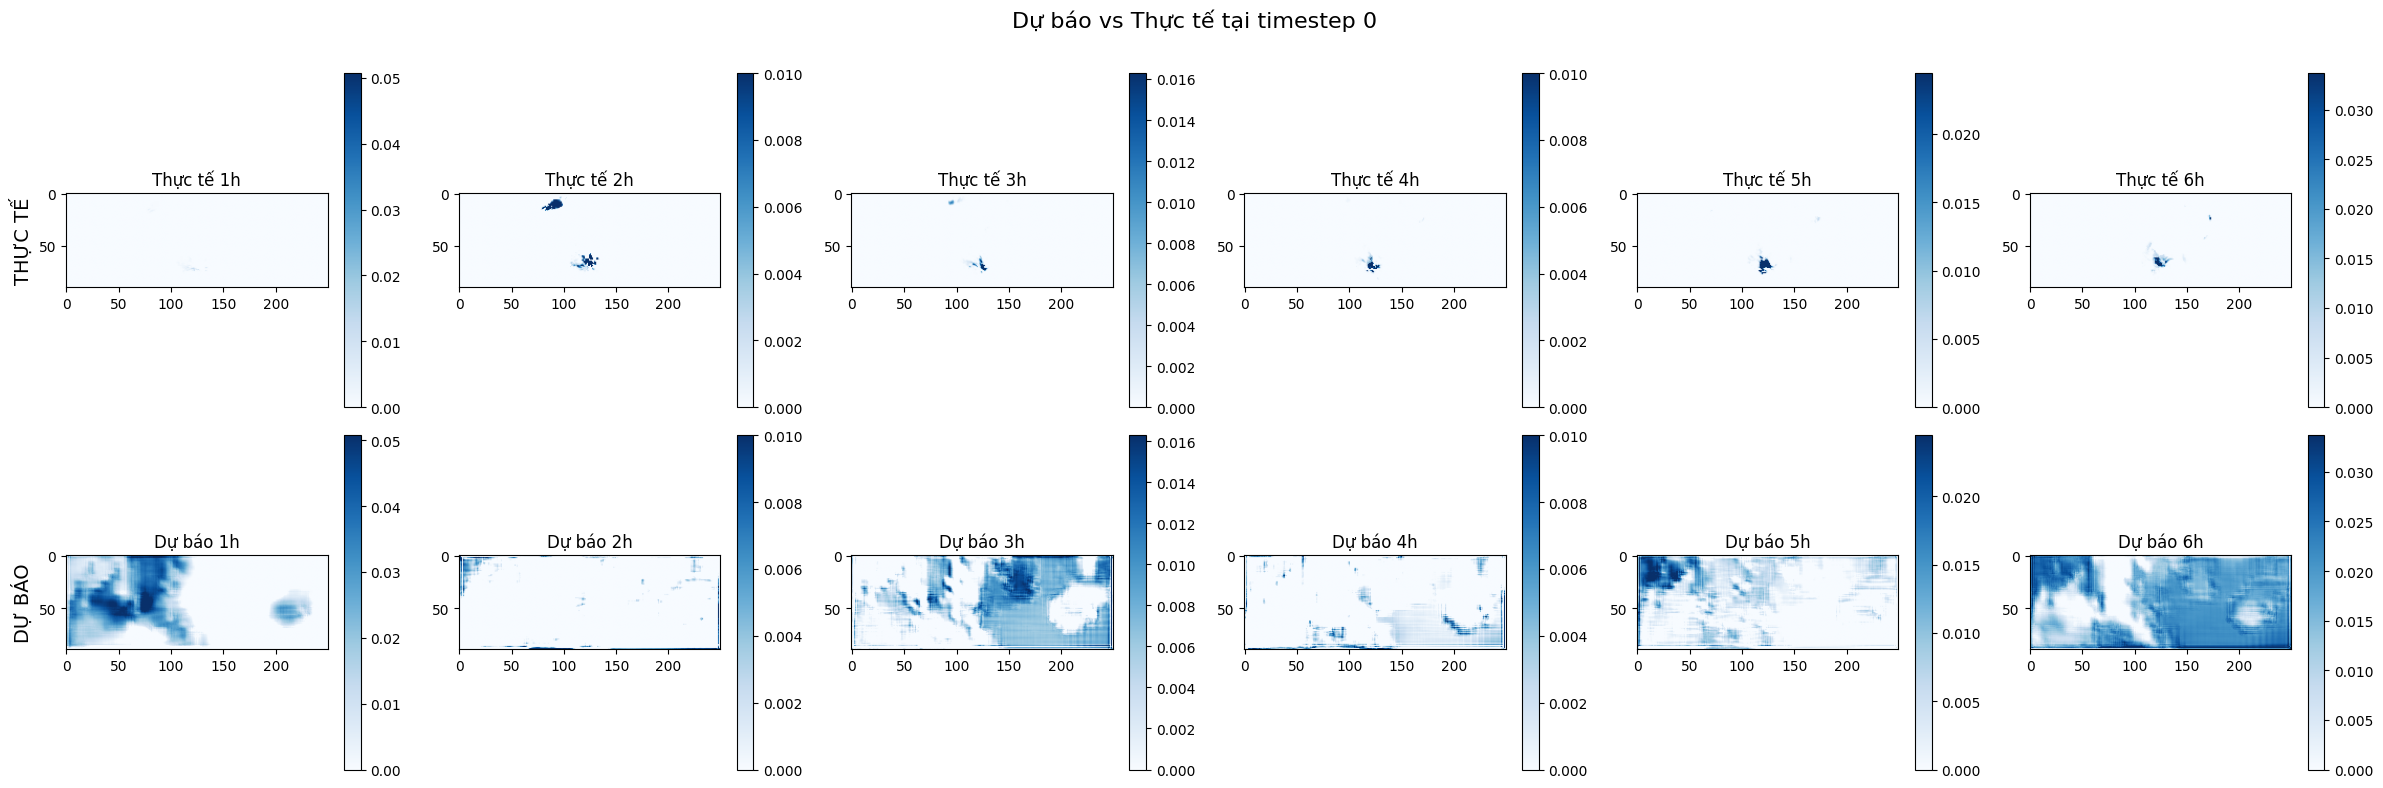

In [8]:

# Tạo danh sách các sample có mưa
nonzero_samples = []
for X_batch, y_batch in ds_train.take(20):  # chỉ duyệt 20 batch cho nhanh
    for i in range(X_batch.shape[0]):
        if tf.reduce_max(y_batch[i]) > 0:
            nonzero_samples.append((X_batch[i:i+1], y_batch[i:i+1]))

# Chọn ngẫu nhiên 1 sample
X_sample, y_sample = random.choice(nonzero_samples)
X_sample, y_sample = X_sample.numpy(), y_sample.numpy()

# Dự báo và hiển thị
y_pred = best_model.predict(X_sample)
visualize_predictions_full_truth(y_sample, y_pred, horizons)